# Tutorial 4 - Pioneer
This tutorial models a potential design for a WEC used to provide power to instruments in the [Pioneer Central Surface Mooring System](https://oceanobservatories.org/site/cp01cnsm/) within the National Science Foundation Ocean Observatories Initiative [Coastal Pioneer Array](https://oceanobservatories.org/array/coastal-pioneer-array/).
This system has instrumentation to measure various meteorological, surface, near-surface, and seabed phenomena on the Continental Shelf-Slope and transmit back to shore.

Unlike previous tutorials, this tutorial does not include an outer optimization loop.
Instead, the focus here is on effectively modeling an optimization problem for the control of a unique WEC archetype with a pitch resonator PTO with several co-dependent components.
This is completely setup in Part 1, and includes:

* Expanding the control state vector
* Custom PTO physics
* Modeling non-hydrodynamic degrees of freedom

This tutorial is divided into three parts.
The first sets up the problem including the points above.
The second and third show results using a regular and irregular wave, respectively.

1. [Model setup](#1.-Model-setup)
2. [Regular wave results](#2.-Regular-wave-results)
3. [Irregular wave](#3.-Irregular-wave)


<p><img src=https://oceanobservatories.org/wp-content/uploads/2015/09/Central-Surface-Mooring-Array-01-1.png alt="Diagram of the Pioneer device" width="200"></p>

In [1]:
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import xarray as xr
from math import comb

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Model setup

### 1.1 Waves
We start with setting up the different waves we want to model, as this will inform what to select for our frequency range, which we need throughout the rest of the problem setup. 
We will consider two waves: a regular wave and an irregular wave, both with typical characteristics of the deployment site.
The regular wave is roughly at 0.35 Hz, the known pitch resonance frequency of the buoy.
The irregular wave has a peak period of 5 seconds, matching that of the deployment site.

Please refer to Tutorial 3 for information about selecting the number of realizations.
For the purpose of the tutorial, the number of realizations has been set to 2 to reduce runtime.

The procedure for determining an appropriate frequency array for irregular wave conditions is detailed at the end of this tutorial.

In [2]:
fend = 1.875
nfreq_irreg = 150
f1_irreg = fend / nfreq_irreg

f1_reg = .325/2
nfreq_reg = 12

In [3]:
# regular
amplitude = 0.15
wavefreq = 0.325
waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)

# irregular
Hs = 1.5
Tp = 5 
nrealizations = 1

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1_irreg, nfreq_irreg, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations=nrealizations)

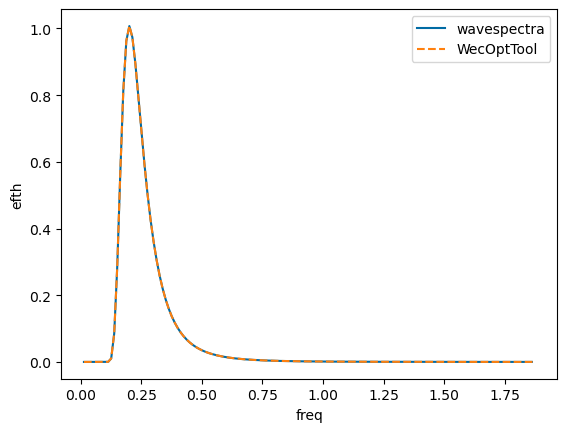

In [23]:
# create PM wave using wavespectra
from wavespectra.construct.frequency import pierson_moskowitz

freq = np.arange(f1_irreg, fend, f1_irreg)

dset = pierson_moskowitz(freq=freq, hs=Hs, fp=fp)
hs = float(dset.spec.hs())
tp = float(dset.spec.tp())
dset.plot(label=f"wavespectra")
plt.plot(waves_irregular['freq'],efth,'--',label='WecOptTool')
ax.set_title('Wave elevation spectrum', fontweight='bold')
plt.legend()

We plot the wave elevation spectra to check if the chosen frequency array covers the main excitation frequency, converges to zero for larger frequencies and can capture multiple harmonics which are required for nonlinear dynamics, since the states are multiplied with each other.

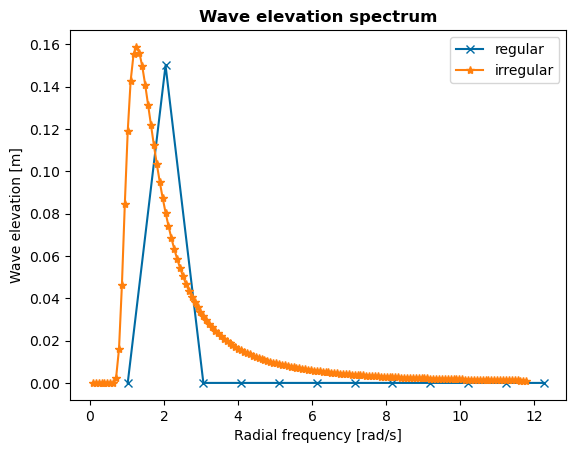

In [ ]:
# check JONSWAP